## Intro

Welcome to my Notebook! <br>

Today we will explore **Ensembling**. <br>
Ensembling is a technique in which we combine various models in a defined way to increase the performance of the final model. <br>
The Dataset that we have here is a Continous Target dataset, which is a **Regression** Problem, and  Ensembling Regression models can be quite tricky. 

In the classification task, just a simple average of probabilities can give a great score boost to our model, but in the regression part taking average might actually decrease your accuracy as we are predicting a continous value and a slight fluctuation can deviate the prediction by a fair amount.

Hence, We need to find best weights to combine our predictions. Here we use a **Gradient boosting** model to find these weights.
This way of combining models is called **Stacking**

Implementing multiple models and then combining their predictions to learning weights again can be daunting, but Scikit-learn provides nice Classes and functions for us to implement them without much hardwork.


Read on to find out more!

### Table of contents

* [Basic EDA](#basiceda) <br>
* [Finding the best Models](#findbestindi) <br>
    * [XGboost](#xgb)<br>
    * [Tuning XGboost with optuna](#tunexgb)<br>
    * [Catboost](#cat)<br>
    * [Tuning Catboost with optuna](#tunecat)<br>
    * [LightGBM](#lgb)<br>
    * [Tuning LightGBM with optuna](#tunelgb)<br>
* [Stacking the models](#stack)<br>
* [Training the Final model](#fin)<br>

In [ ]:
!pip install -q --upgrade pip
!pip install -q seaborn==0.11.1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgbm

import optuna
from optuna import Trial, visualization

In [ ]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2021/test.csv')
sub = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2021/sample_submission.csv')

<div id="basiceda"> </div>

### Basic EDA 

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
sub.head()

In [ ]:
print(f"Train shape - {train.shape}\nTest shape - {test.shape}")

In [ ]:
train.describe()

Things to note about the features -- 
* All the Variables are numerical here.
* They have similar mean and std (We have to analyze their distributions to arrive at a specific conclusion)
* They might have negative values too
* They max out around 1

Plotting the distributions for the features will give us a fair idea about them

In [ ]:
feats = [col for col in train.columns.tolist() if col.startswith('cont')]


fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,15))

fig.tight_layout()
plt.subplots_adjust(bottom=0.1, top=1.5)
i = 0
for row in ax:
    for col in row:
        sns.histplot(data = train, x=feats[i], ax=col)
        col.xaxis.label.set_visible(False)
        col.yaxis.label.set_visible(False)
        col.set_title(feats[i])
        i += 1
        
plt.show()

We can see that all the distributions are skewed, hence if we use Linear models we should make it normal by applying transformations!

In [ ]:
# separating the target and features

X = train.drop(['target', 'id'], axis=1).values
y = train['target'].values
Xtest = test.drop('id', axis=1).values

X.shape, y.shape, Xtest.shape

<div id="findbestindi"> </div>

## Finding the Best Individual Models

First we will try to find best individual Models for Regression

<div id="xgb"> </div>

### XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

# making 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# defining model
xgbreg = XGBRegressor(tree_method='gpu_hist')

# taking positive because cross val score returns -ve values
scores = np.abs(cross_val_score(xgbreg, X, y, cv=kf, scoring='neg_root_mean_squared_error'))

# printing the output
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

The Score is good, but I am sure we can do better. 

<div id="tunexgb"> </div>

### Tuning the XGBoost Model

Tuning with optuna is really simple, we just need to make a function that we need to optimize and then start optimizing. Here I have made an **Objective** to optimize. Optuna can also produce some amazaing visuals, check [this](https://www.kaggle.com/debarshichanda/optuna-automated-hyperparameter-tuning) out for example.

In [ ]:
"""This function will return our cv score which we are aiming to minimize"""
def Objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [150, 200, 250, 300]),
        "eta": trial.suggest_loguniform("eta",1e-2,0.1),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6,1,0.1),
        "min_child_weight": trial.suggest_int("min_child_weight",5,11),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1),
        "max_depth": trial.suggest_categorical("max_depth",[5,7,9,11,13]),
        "random_state": 2021
    }
    
    model = XGBRegressor(**params, tree_method='gpu_hist')
    
    
    # taking positive because cross val score returns -ve values
    scores = np.abs(cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error'))
    
    return sum(scores)/len(scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name='Xgboost optimization')
study.optimize(Objective, n_trials=20)

We improved our model from 0.7031 to 0.6988! thats a lot of improvement

In [ ]:
XGB_params = study.best_params

study.best_params

<div id="cat"> </div>

### CatBoost

In [ ]:
# defining model
catreg = CatBoostRegressor(task_type='GPU', verbose=0)

# taking positive because cross val score returns -ve values
scores = np.abs(cross_val_score(catreg, X, y, cv=kf, scoring='neg_root_mean_squared_error'))

# printing the output
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

<div id="tunecat"> </div>

### Tuning the Catboost model

In [ ]:
"""This function will return our cv score which we are aiming to minimize"""
def Objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [150, 200, 250, 300, 350]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.5),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6,1,0.1),
        "max_depth": trial.suggest_categorical("max_depth",[5,7,9,11,13]),
        #"colsample_bylevel": trial.suggest_categorial("colsample_bylevel", [0.3,0.4,0.5,0.6,0.7,0.8])
        # the colsample_bylevel also improves the score a lot, but its commented out because its not supported on GPU currently.
        # If you are interested, do fork the kernel, and try it out. I reached a score of 0.7004 while tuning with it.
        "random_state": 2021
    }
    
    
    model = CatBoostRegressor(**params, task_type="GPU", verbose=0)
    
    
    # taking positive because cross val score returns -ve values
    scores = np.abs(cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error'))
    
    return sum(scores)/len(scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name='Catboost optimization')
study.optimize(Objective, n_trials=20)

We improved our model from 0.7116 to 0.7089!

In [ ]:
catboost_params = study.best_params
study.best_params

<div id="lgb"> </div>

### LightGBM

In [ ]:
lgbreg = lgbm.LGBMRegressor(device_type='gpu')

# taking positive because cross val score returns -ve values
scores = np.abs(cross_val_score(lgbreg, X, y, cv=kf, scoring='neg_root_mean_squared_error'))

# printing the output
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

<div id="tunelgb"> </div>

### Tuning the LightGBM Model

In [ ]:
"""This function will return our cv score which we are aiming to minimize"""
def Objective(trial):
    params = {
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    model = lgbm.LGBMRegressor(**params, device='GPU')
    
    
    # taking positive because cross val score returns -ve values
    scores = np.abs(cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error'))
    
    return sum(scores)/len(scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name='LGBM optimization')
study.optimize(Objective, n_trials=20)

 We improved our model from 0.7027 to 0.6984! That is again a lot of improvement

In [ ]:
lgb_params = study.best_params
study.best_params

<div id="stack"> </div>

## Stacking our Models

Now that we have got our models built, we will combine them

We will keep the Models that we built before as **LEVEL 1** models and keep a Gradient Boosting Regressor as a **LEVEL 2** Model.

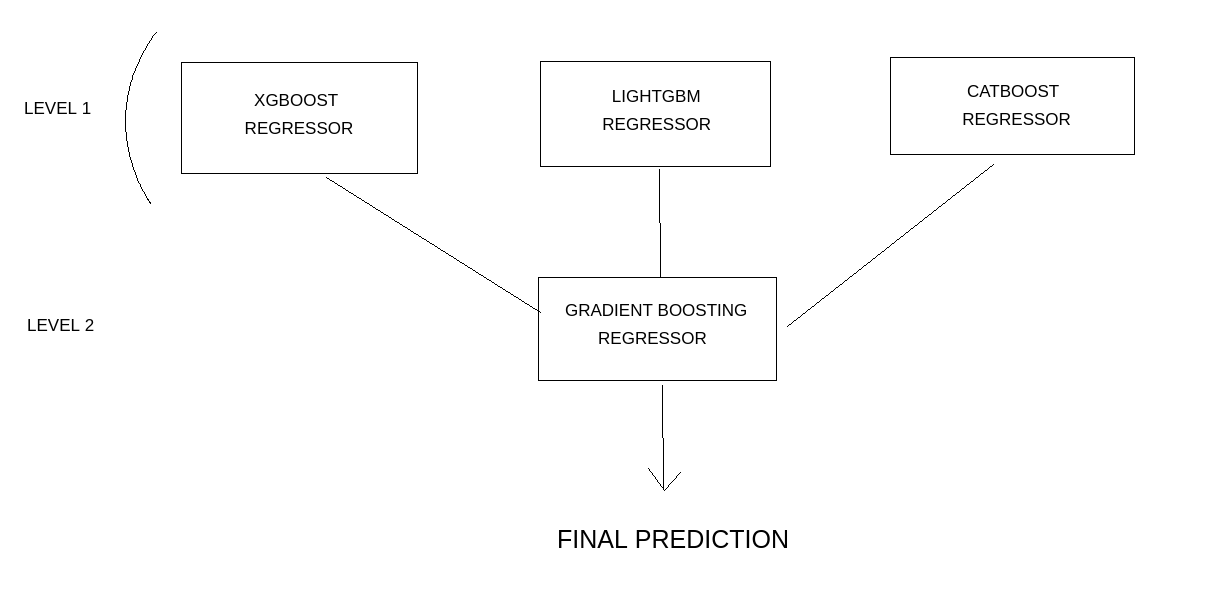

This System might look hard to build, but Scikit-learn provides us a Class **Stacking Regressor** To attach various base estimators with a final estimators.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

final_estimator = GradientBoostingRegressor(n_estimators=200, 
                                            random_state=42)

estimators = [('xgb', XGBRegressor(tree_method='gpu_hist', **XGB_params)),
              ('lgb', lgbm.LGBMRegressor(device_type='gpu',**lgb_params)),  
              ('cat', CatBoostRegressor(verbose=0, task_type='GPU', **catboost_params))] 

reg = StackingRegressor(
        estimators=estimators,
         final_estimator=final_estimator)

In [ ]:
# taking positive because cross val score returns -ve values
scores = np.abs(cross_val_score(reg, X, y, cv=kf, scoring='neg_root_mean_squared_error'))

# printing the output
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

### This score is better than any of our previous models!!! That is the power of ensembling.

<div id="fin"> </div>

## Training the final model and submission

In [ ]:
# training the final model and generating the submission.

reg.fit(X, y)
sub['target']=reg.predict(Xtest)
sub.to_csv('submission.csv', index=False)

This submission scores 0.69931! 

**If you find the notebook useful or if it helps you, Consider UPVOTING my notebook!**